# TIFF vs GeoTIFF
Tagged Image File Format (TIFF) is a variable-resolution bitmapped image format. TIFF files are large and of very high quality. These are common for storing raster graphics images, popular among graphic artists, the publishing industry and photographers. TIFF files can contain tags, additional items of information, that can be used to extend the standard for different purposes.

GeoTIFF is nothing but a TIFF file with additional tags that provide extra information for that image as specified by the GeoTIFF standard. Hence, it allows georeferencing information to be embedded within a TIFF file. In other words, it is metadata along with TIFF file.

In [6]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import glob
plt.rcParams['image.cmap'] = 'gray'
from osgeo import gdal

# Geospatial Data Abstraction Library (GDAL)
GDAL is a translator library for raster and vector geospatial data formats. The GDAL python package includes a number of tools for programming and manipulating the Geospatial Data Abstraction Library.

One concept to understand is a raster band. Most color images have 3 raster bands, representing the b, g, and r components describing light intensities. However, a raster band could be any spatially coincident matrices of cell values representing the same spatial area, not just channel brightness information.

# Opening Geotiff File
Open() allows you to open a reference to a GeoTIFF file so you can later extract any raster bands you like.

Function Syntax
dataset = gdal.Open( filename )
The function has 1 required input argument:

filename path of file to open.

In [8]:
ds = gdal.Open('../module03-histograms-and-color-segmentation/Applications/deforestation/2001api.tif')

# Fetching a Raster Band
Raster data via GDAL is done one band at a time. GetRasterBand() allows to extract a single raster band from the GeoTiff image.

Function Syntax
band = dataset.GetRasterBand( n )
The function has 1 required input argument:

- n the channel number to be extracted

# Extract the various bands from the GeoTIFF Image
There are 7 bands in the Landsat5 image data. They are:

- Blue
- Green
- Red
- Near Infrared (NIR)
- Short-wave Infrared (SWIR) 1
- Thermal
- Short-wave Infrared (SWIR) 2
Let us see how they look like.

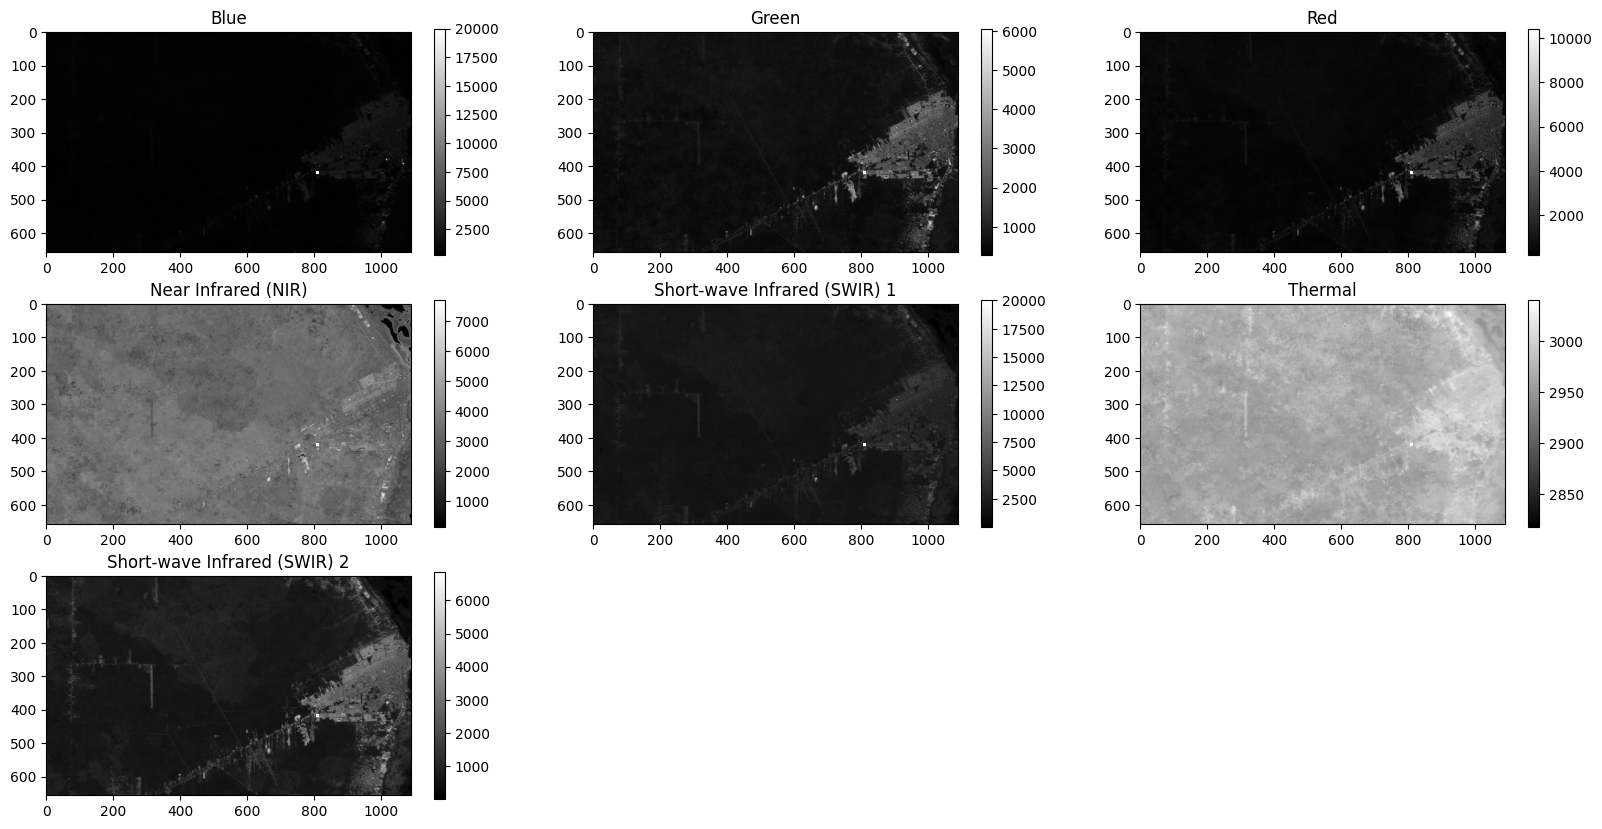

In [9]:
plt.figure(figsize = (20,10))
plt.subplot(331); plt.imshow(ds.GetRasterBand(1).ReadAsArray()); plt.title("Blue"); plt.colorbar();
plt.subplot(332); plt.imshow(ds.GetRasterBand(2).ReadAsArray()); plt.title("Green"); plt.colorbar();
plt.subplot(333); plt.imshow(ds.GetRasterBand(3).ReadAsArray()); plt.title("Red"); plt.colorbar();
plt.subplot(334); plt.imshow(ds.GetRasterBand(4).ReadAsArray()); plt.title("Near Infrared (NIR)"); plt.colorbar();
plt.subplot(335); plt.imshow(ds.GetRasterBand(5).ReadAsArray()); plt.title("Short-wave Infrared (SWIR) 1"); plt.colorbar();
plt.subplot(336); plt.imshow(ds.GetRasterBand(6).ReadAsArray()); plt.title("Thermal"); plt.colorbar();
plt.subplot(337); plt.imshow(ds.GetRasterBand(7).ReadAsArray()); plt.title("Short-wave Infrared (SWIR) 2"); plt.colorbar();

# Normalized Difference Vegetation Index (NDVI)
Normalized difference vegetation index or NDVI is an index that is used to demonstrate the difference between the visible and near-infrared reflectance of vegetation cover and can be used to estimate the density of green on an area of land.
The NDVI is calculated as:

 NDVI = (NIR - RED) / (NIR  + RED)
where Red and NIR stand for the spectral reflectance measurements acquired in the red (visible) and near-infrared regions, respectively. The NDVI score for an area with vegetation should lie between 0.3 ( light vegetation ) to 0.8 ( heavy vegetation ). Clouds will have a negative index, while soil and bodies of water will have low positive values. We will use this information to estimate the vegetation of a certain region.

# Near Infra Red Region (NIR)
NIR has a wavelength of 0.76 - 0.90 µm. Plant life absorbs visible light from 0.4 µm (blue light) and up to 0.7 µm (red light) for photosynthesis, with peak absorption towards both ends of this spectrum. We see plants as green because they typically don't absorb the green wavelengths of light (~0.5 µm) in the middle of this range. However, this does make the green channel less accurate for detection of vegetation because it falls within the full range of wavelengths used for photosynthesis. On the other hand, plants strongly reflects near-infrared light (from 0.7 to 1.1 µm). This fact is exploited in calculating NDVI.

# Calculate the NDVI from Landsat5 Images
The NDVI is calculated from the Red and NIR Bands. In LandSat5, these are the 3rd and 4th bands. So, we will use GDAL to get those bands and calculate NDVI.

In [10]:
def get_NDVI(ds):
    r = ds.GetRasterBand(3).ReadAsArray()
    nir = ds.GetRasterBand(4).ReadAsArray()
    ndvi = (nir - r)/(nir + r)
    ndvi = normalize255(ndvi)
    return ndvi

# Normalize ndvi from (-1, 1) to (0, 255)

In [12]:
def normalize255(ndvi):
    ndvi = ndvi + 1
    ndvi = (ndvi / 2) * 255
    return ndvi

# Get Segmented mask of NDVI
As discussed earlier, The NDVI score for an area with vegetation should lie between 0.3 ( light vegetation ) to 0.8 ( heavy vegetation ). Since we have normalized the values to (0, 255), these correspond to 165 and 230.

We will use 200 ( midway between 0.3 and 0.8 ) as our threshold to estimate forest area.

In [13]:
 def get_NDVI_mask(ndvi):
    _, mask = cv2.threshold(ndvi, 200, 255, cv2.THRESH_BINARY)
    return mask

# Calculate the percentage of forestation using the generated mask

In [14]:
def percent_forest(mask):
    c = cv2.countNonZero(mask)
    t = mask.shape[0] * mask.shape[1]
    return round((c / t) * 100, 4)

# Calculate and Plot NDVI and segmented mask
We will use this function to plot the NDVI and the mask generated for forest area and display the results.

In [15]:
def plot_NDVI(path):
    ds = gdal.Open(path)
    ndvi = get_NDVI(ds)
    ndvi_mask = get_NDVI_mask(ndvi)

    year = path.split('.')[0][:4]
    fig = plt.figure(figsize = (20, 5))
    fig = plt.subplot(1, 2, 1)
    plot = plt.imshow(ndvi, cmap = "gray")
    plt.colorbar()
    plt.title(year + ": " + "NDVI") 
    plt.xticks([]), plt.yticks([])
    fig = plt.subplot(1, 2, 2)
    plot = plt.imshow(ndvi_mask, cmap = "gray"); 
    plt.title(str(percent_forest(ndvi_mask)) + "%") 
    plt.xticks([]), plt.yticks([])
    plt.show()

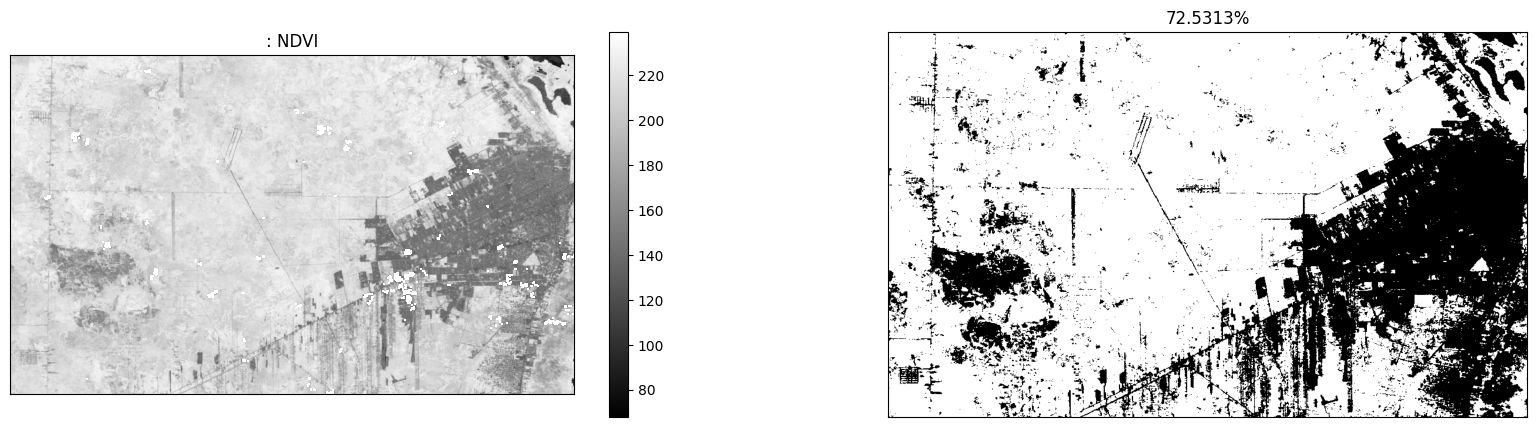

In [17]:
plot_NDVI('../module03-histograms-and-color-segmentation/Applications/deforestation/2011api.tif')

# Plotting all years of data
The White portion in the Mask demonstrates the Forested sections of the area based on NDVI.

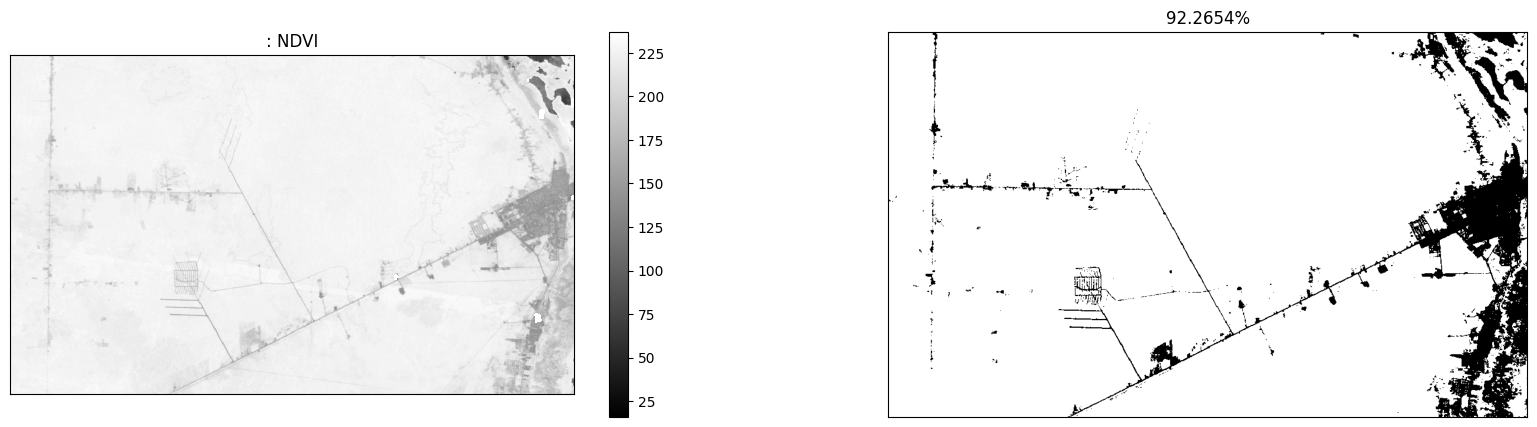

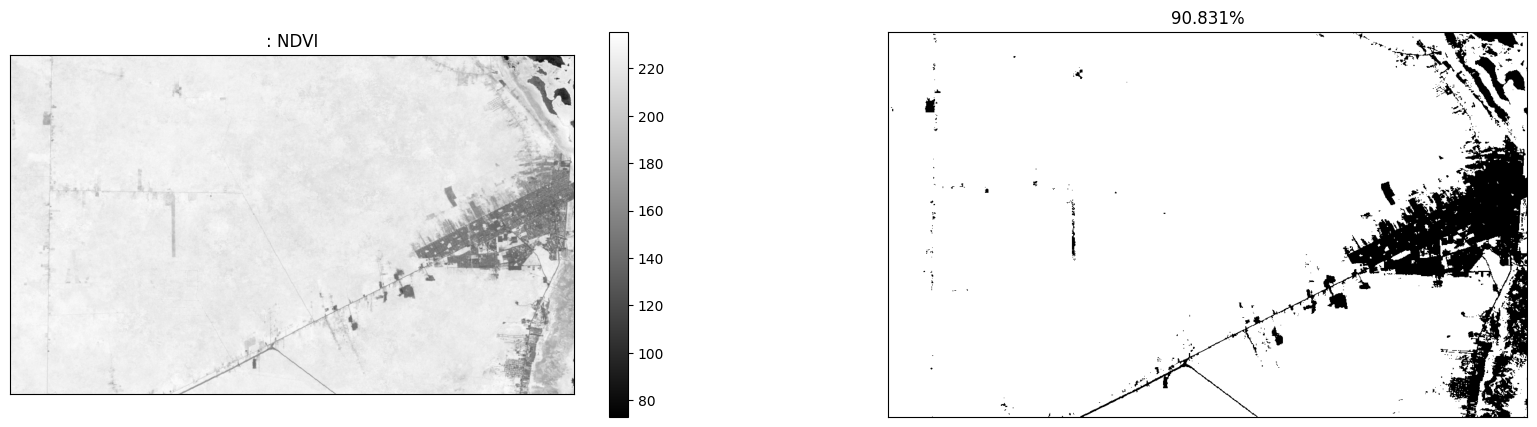

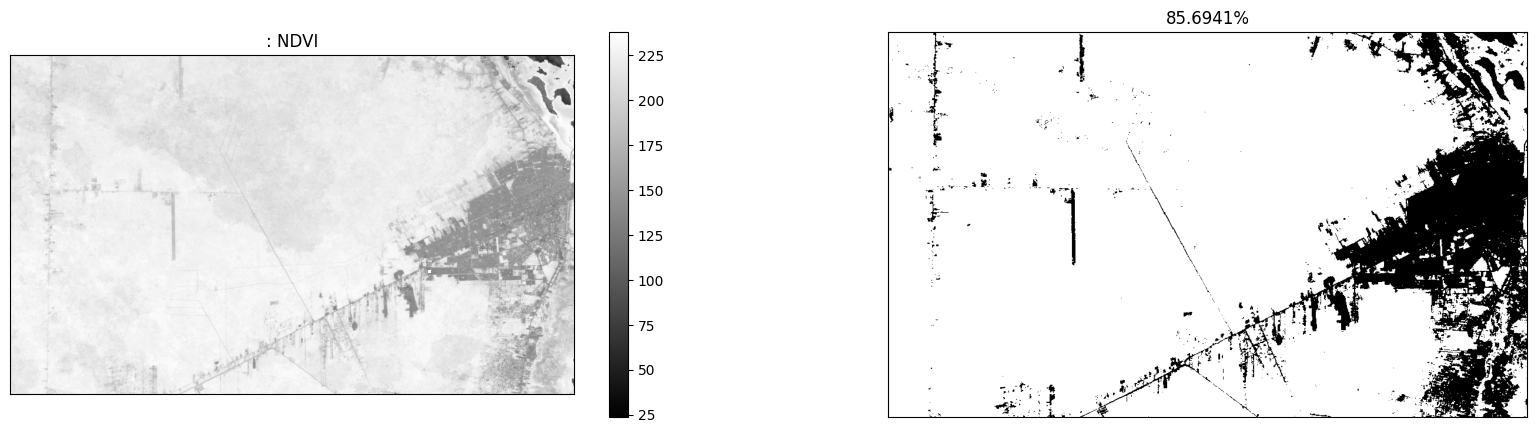

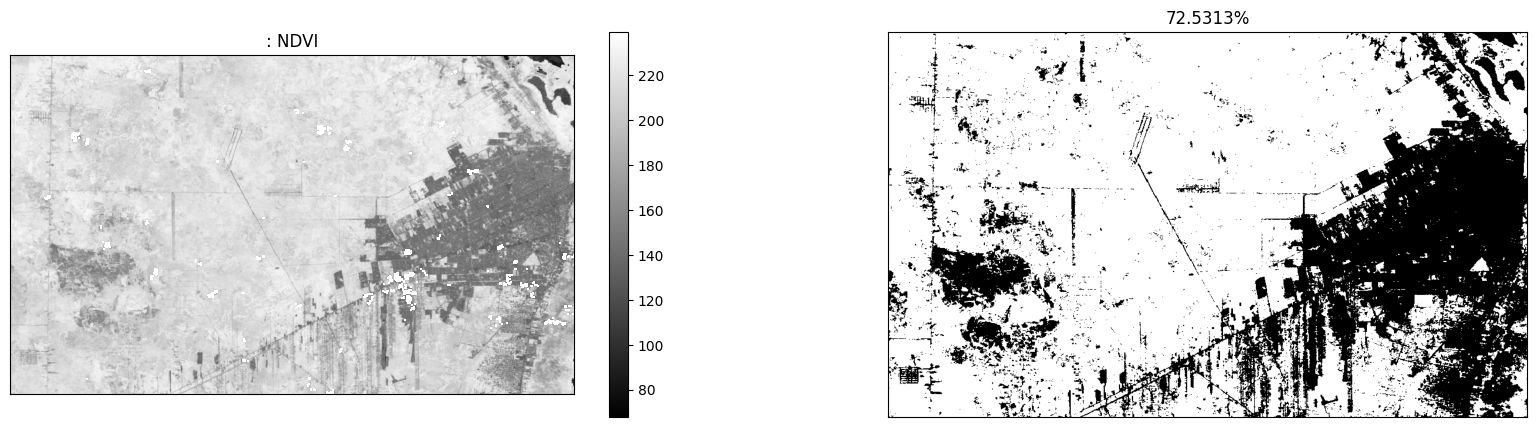

In [19]:
geotiff_files = glob.glob("../module03-histograms-and-color-segmentation/Applications/deforestation/*.tif")
geotiff_files.sort()
for file in geotiff_files:
    plot_NDVI(file)